In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import pickle
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from prettytable import PrettyTable
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.markers import MarkerStyle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

data_names = npzfile.files
n_files = len(npzfile.files)

new_datas = [0]*n_files
for i in range(n_files):
    new_datas[i] = npzfile[data_names[i]]

print(data_names)
print(new_datas)
print(new_datas[0].shape)
print(new_datas[3].shape)

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
[array([1979, 1979, 1979, ..., 2022, 2022, 2022]), array([ 1,  1,  1, ..., 11, 11, 11]), array([ 1,  2,  3, ..., 14, 15, 16]), array([ 0.142507  , -0.2042    , -0.15861   , ...,  0.63895518,
        0.71995491,  0.67032343]), array([ 1.05047   ,  1.37361   ,  1.53943   , ..., -0.39565107,
       -0.2206952 , -0.1839911 ]), array([6., 7., 7., ..., 4., 4., 4.]), array([1.0600899 , 1.3887    , 1.54758   , ..., 0.7515341 , 0.75302154,
       0.69511598])]
(16026,)
(16026,)


In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = False

N = len(new_datas[0]) # the total number of days in new dataset
n = 10000 # the number of days for training
c = 365 # the number of dropped buffer set
m = N-n-c # the number of days for testing


n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]
n1s=[4698]

palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

In [4]:
print(m)

5661


In [5]:
max_lead_time = m + 1 - max(widths)
lead_time = 60
n_pred = 365*2 # 14*365
# width + lead_time + n_pred-1 <= m

## $Mat\acute{e}rn$ $1/2$

### Independent RMMs with $Mat\acute{e}rn$ $1/2$

In [6]:
# Independent
dics_total_matern12 = {}
cor_total_matern12 = {}
rmse_total_matern12 = {}
phase_err_total_matern12 = {}
amplitude_err_total_matern12 = {}

t = PrettyTable([ "width", "RMMs", "lengthscale"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_matern12[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for data_name in ['RMM1','RMM2']:
            mjo_model.train_mjo(data_name)
            mjo_model.pred_mjo(data_name, lead_time, n_pred)

            t.add_rows( [[f'{width}', f'{data_name}', f'{mjo_model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0]}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_matern12[n1] = cor_width
    rmse_total_matern12[n1] = rmse_width
    phase_err_total_matern12[n1] = phase_err_width
    amplitude_err_total_matern12[n1] = amplitude_err_width

matern12_independ = {'cor': cor_total_matern12, 'rmse': rmse_total_matern12, 
                     'phase': phase_err_total_matern12, 'amplitude': amplitude_err_total_matern12,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/matern12_independ.pkl','wb')
pickle.dump(matern12_independ, dic_pkl)

print(f'Matern 1/2 with independent RMMs:')
print(t)

Matern 1/2 with independent RMMs:
+-------+------+-------------+
| width | RMMs | lengthscale |
+-------+------+-------------+
|   40  | RMM1 | [7.5297728] |
|   40  | RMM2 | [18.492464] |
|   60  | RMM1 |   [33.325]  |
|   60  | RMM2 | [49.119686] |
|   80  | RMM1 |  [67.5893]  |
|   80  | RMM2 |  [84.75696] |
+-------+------+-------------+


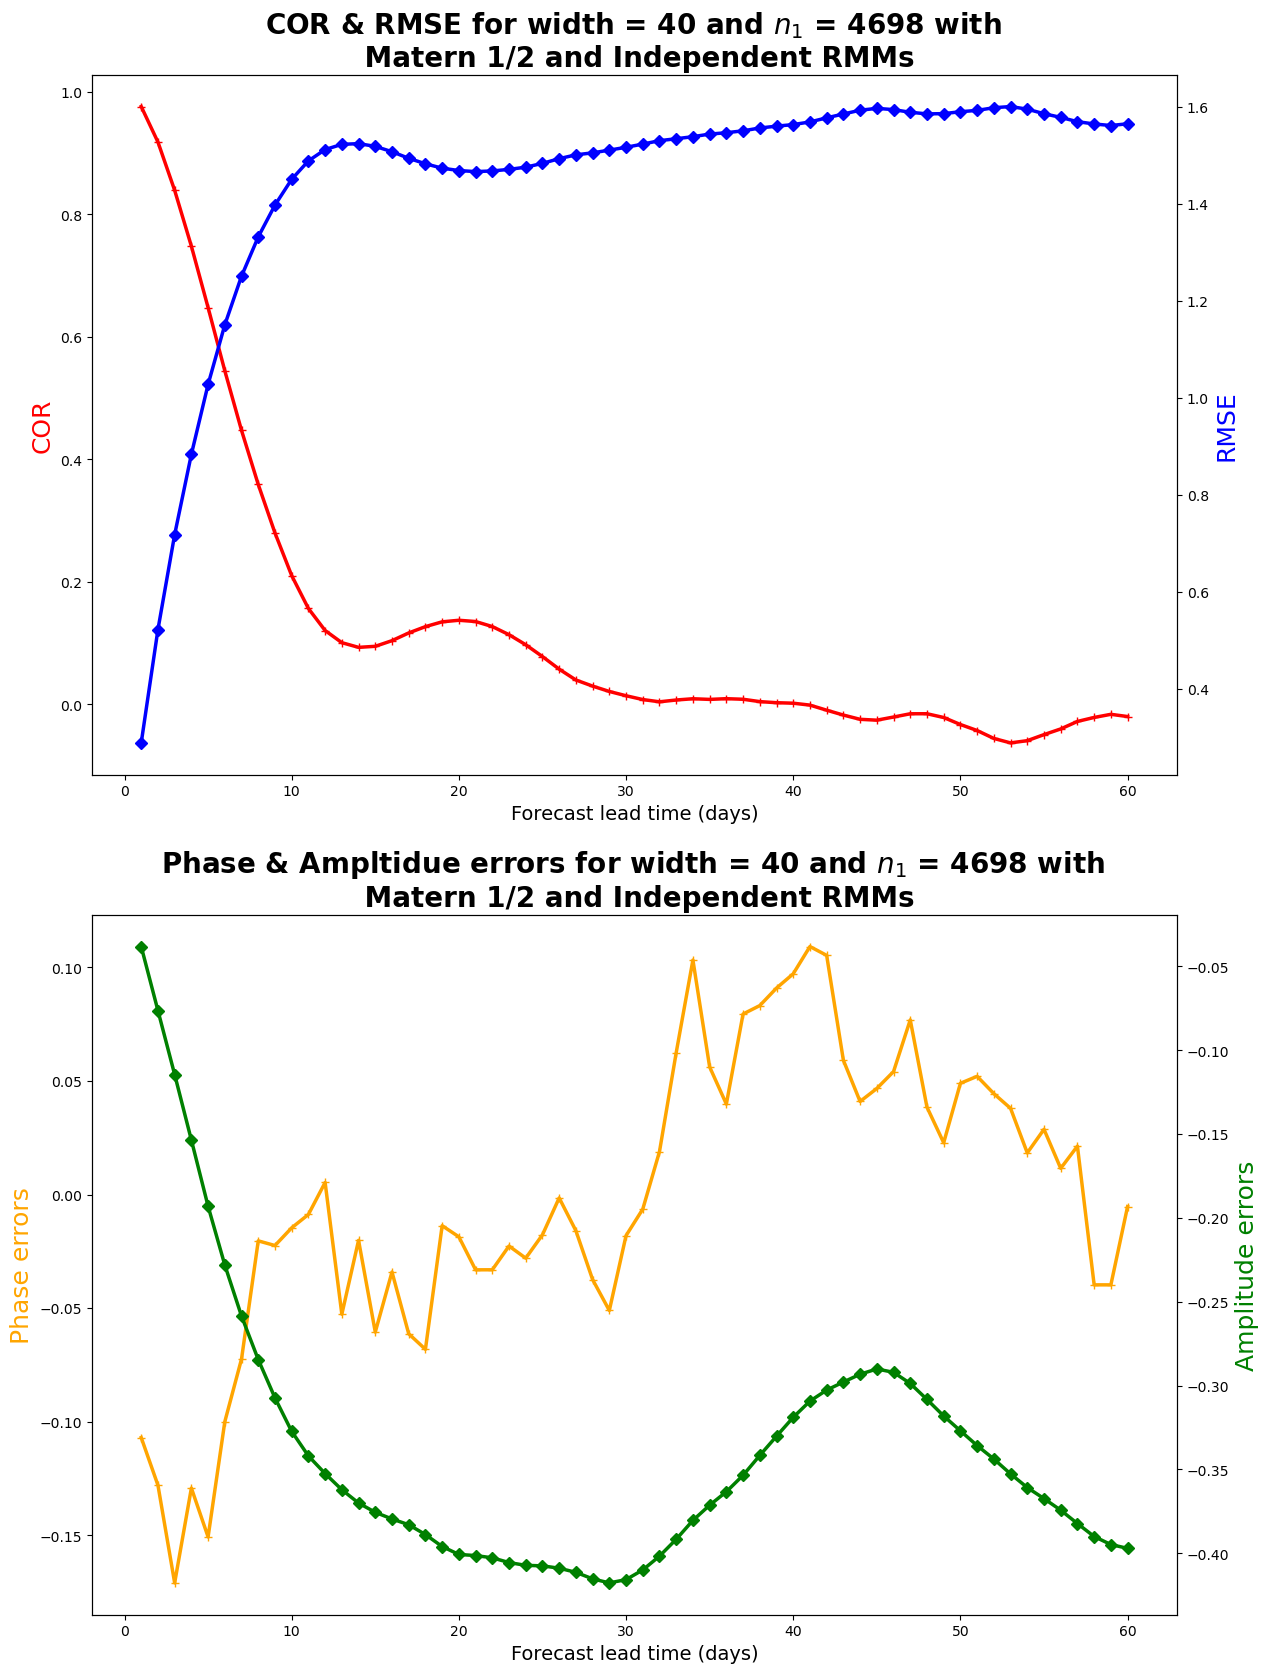

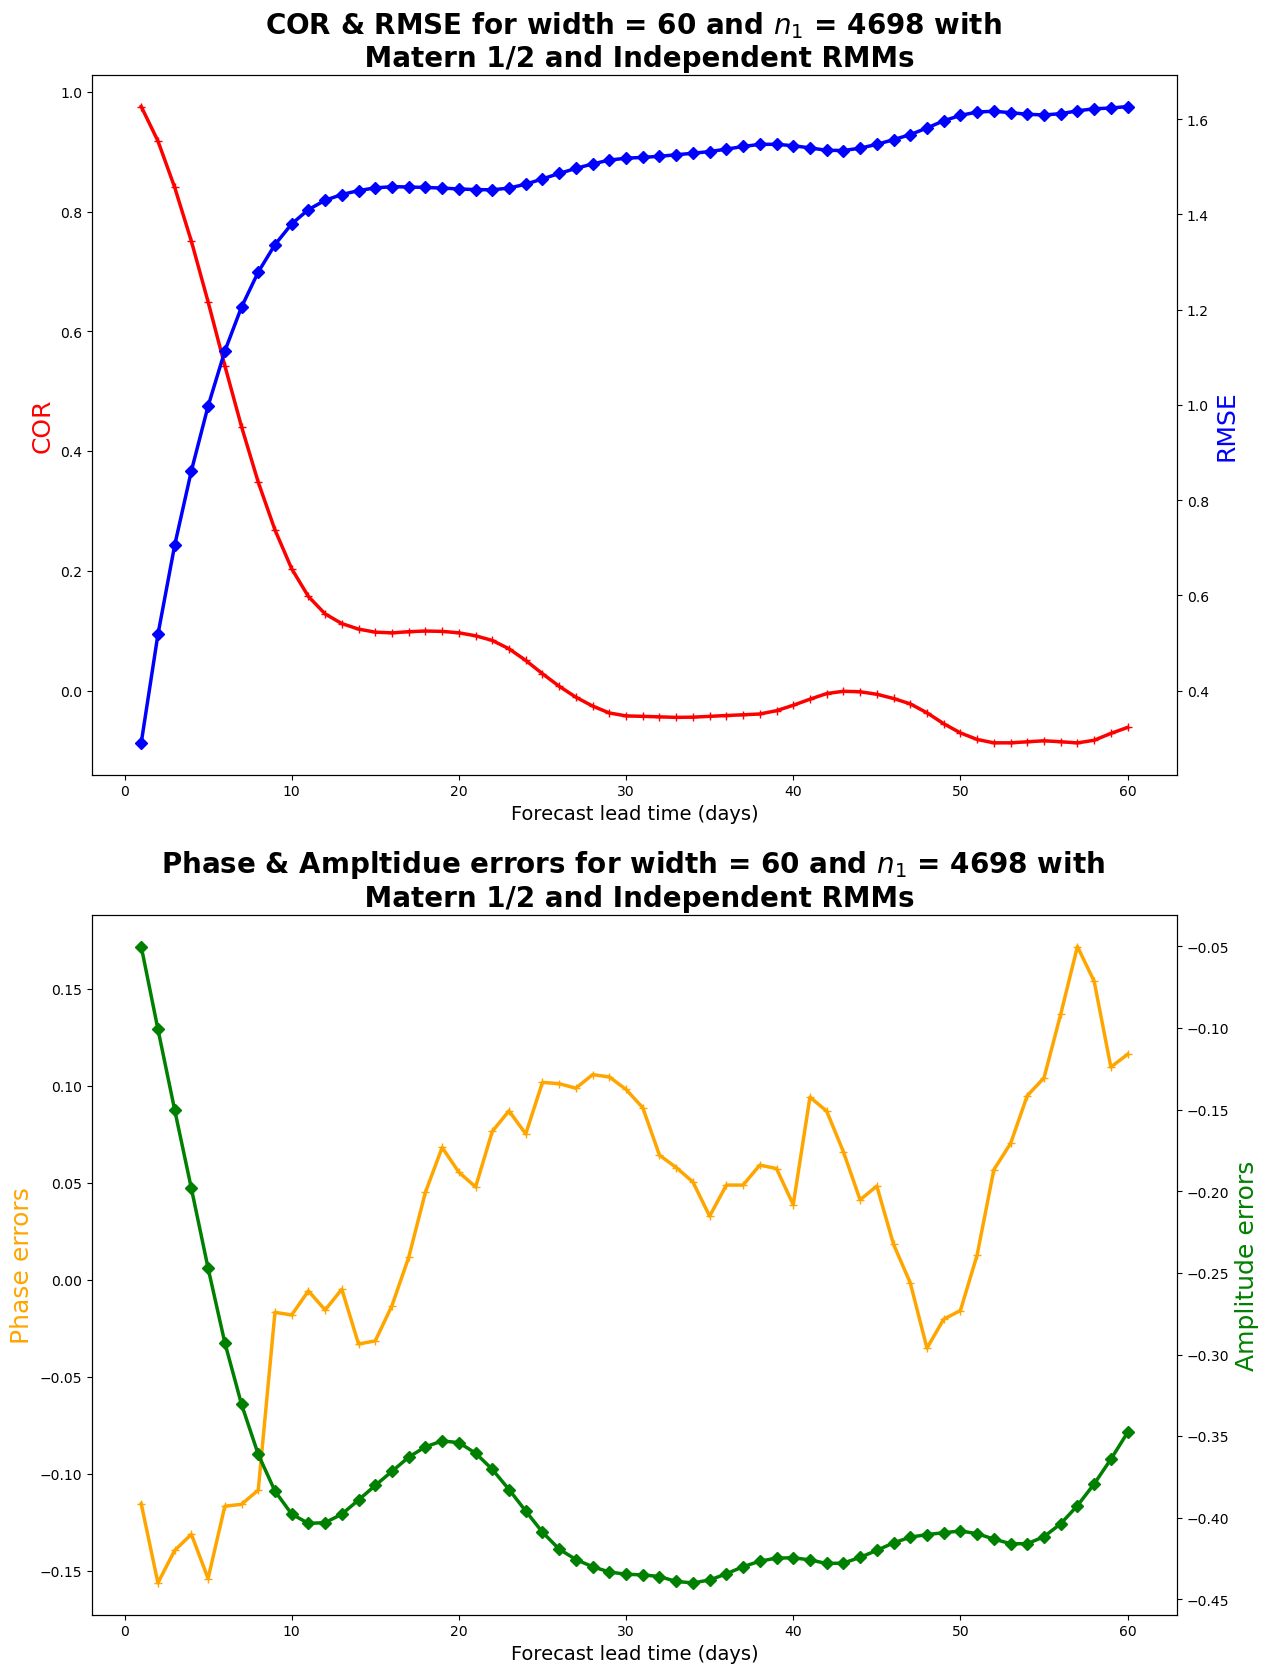

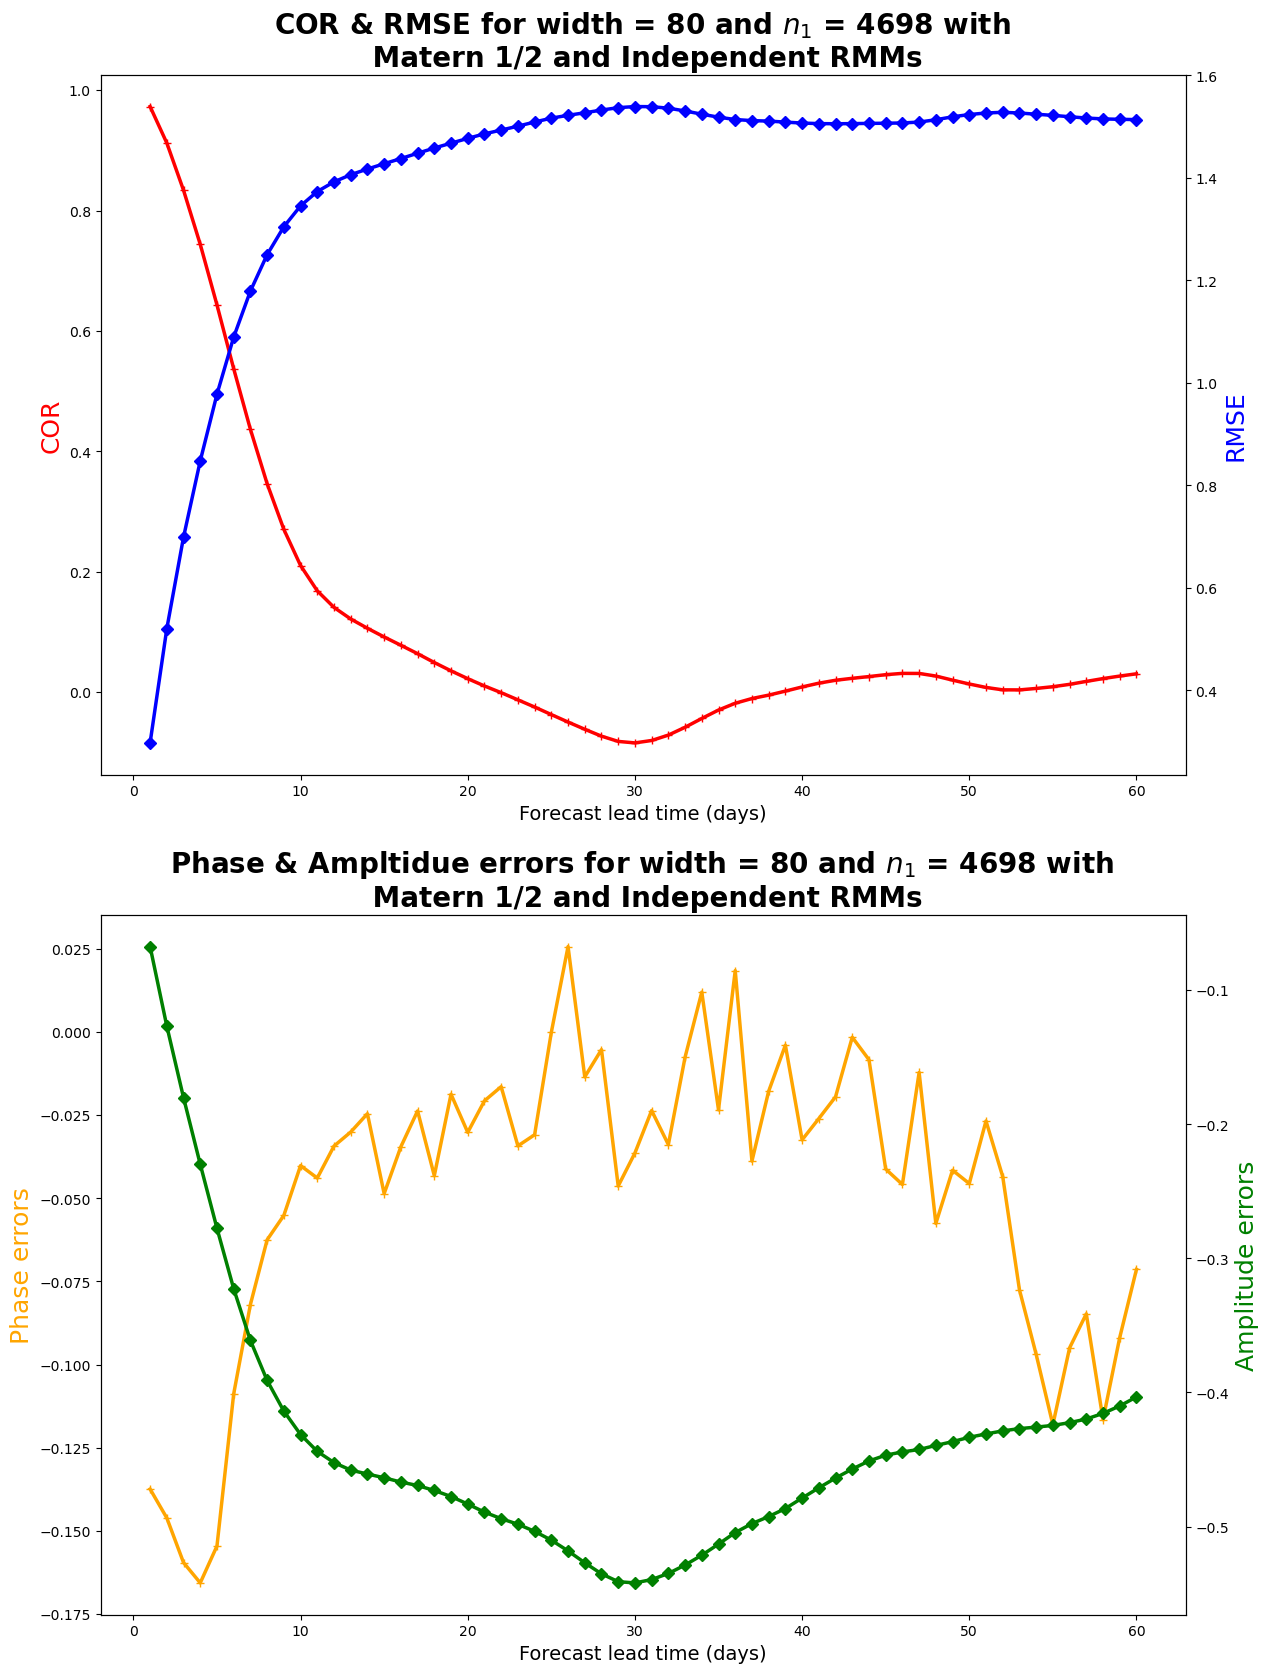

In [7]:
load_file = open('../data/preds/entire/matern12_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())

# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Matern 1/2 and Independent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Matern 1/2 and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs with $Mat\acute{e}rn$ $1/2$

In [8]:
# Dependent
dics_total_dependmatern12 = {}
cor_total_dependmatern12 = {}
rmse_total_dependmatern12 = {}
phase_err_total_dependmatern12 = {}
amplitude_err_total_dependmatern12 = {}

t = PrettyTable(["width", "RMMs", "lengthscale"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_dependmatern12[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        mjo_model.train_mjo(Depend=True)
        for data_name in ['RMM1','RMM2']:
            mjo_model.pred_mjo(data_name, lead_time, n_pred)
        t.add_rows( [[f'{width}', 'dependent', f'{mjo_model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0]}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_dependmatern12[n1] = cor_width
    rmse_total_dependmatern12[n1] = rmse_width
    phase_err_total_dependmatern12[n1] = phase_err_width
    amplitude_err_total_dependmatern12[n1] = amplitude_err_width

matern12_depend = {'cor': cor_total_dependmatern12, 'rmse': rmse_total_dependmatern12, 
                     'phase': phase_err_total_dependmatern12, 'amplitude': amplitude_err_total_dependmatern12,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/matern12_depend.pkl','wb')
pickle.dump(matern12_depend, dic_pkl)

print(f'Matern 1/2 with dependent RMMs:')
print(t)

Matern 1/2 with dependent RMMs:
+-------+-----------+--------------+
| width |    RMMs   | lengthscale  |
+-------+-----------+--------------+
|   40  | dependent | [93.493904]  |
|   60  | dependent | [104.56989]  |
|   80  | dependent | [115.816826] |
+-------+-----------+--------------+


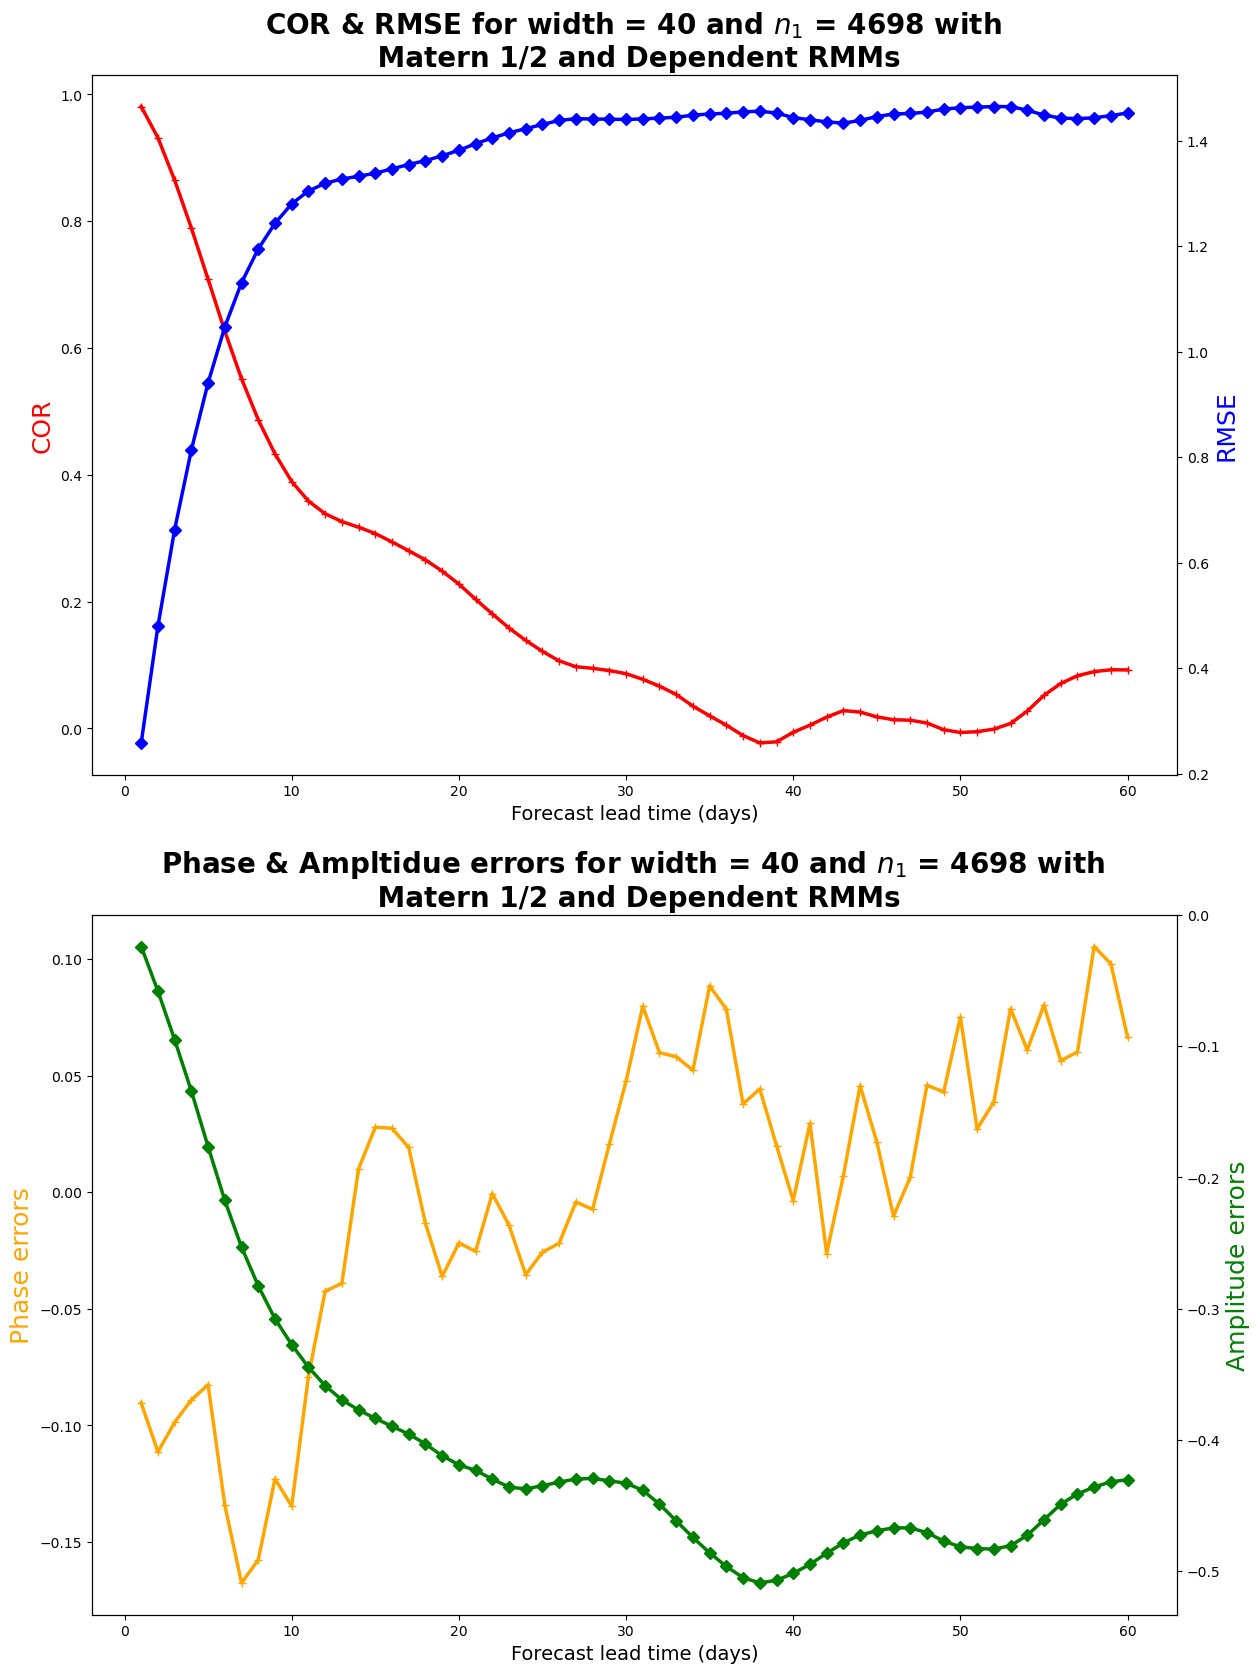

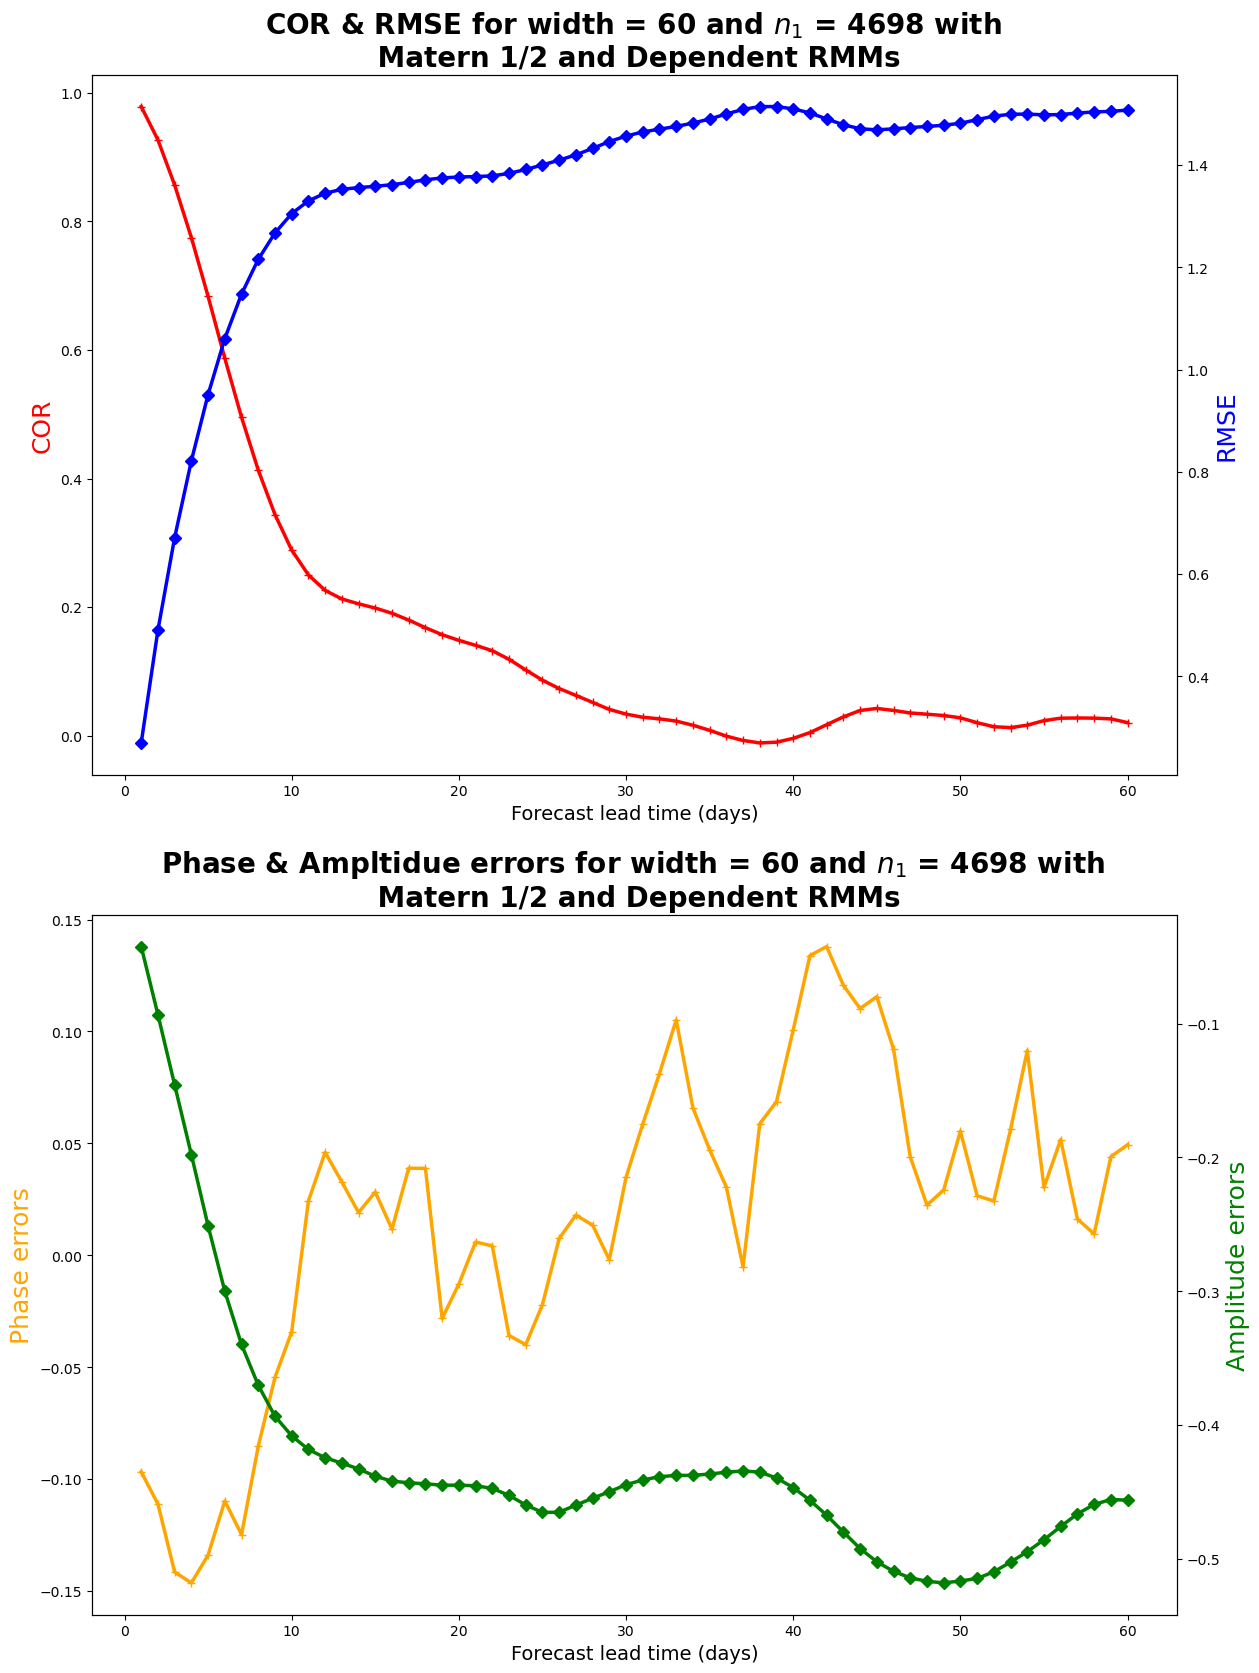

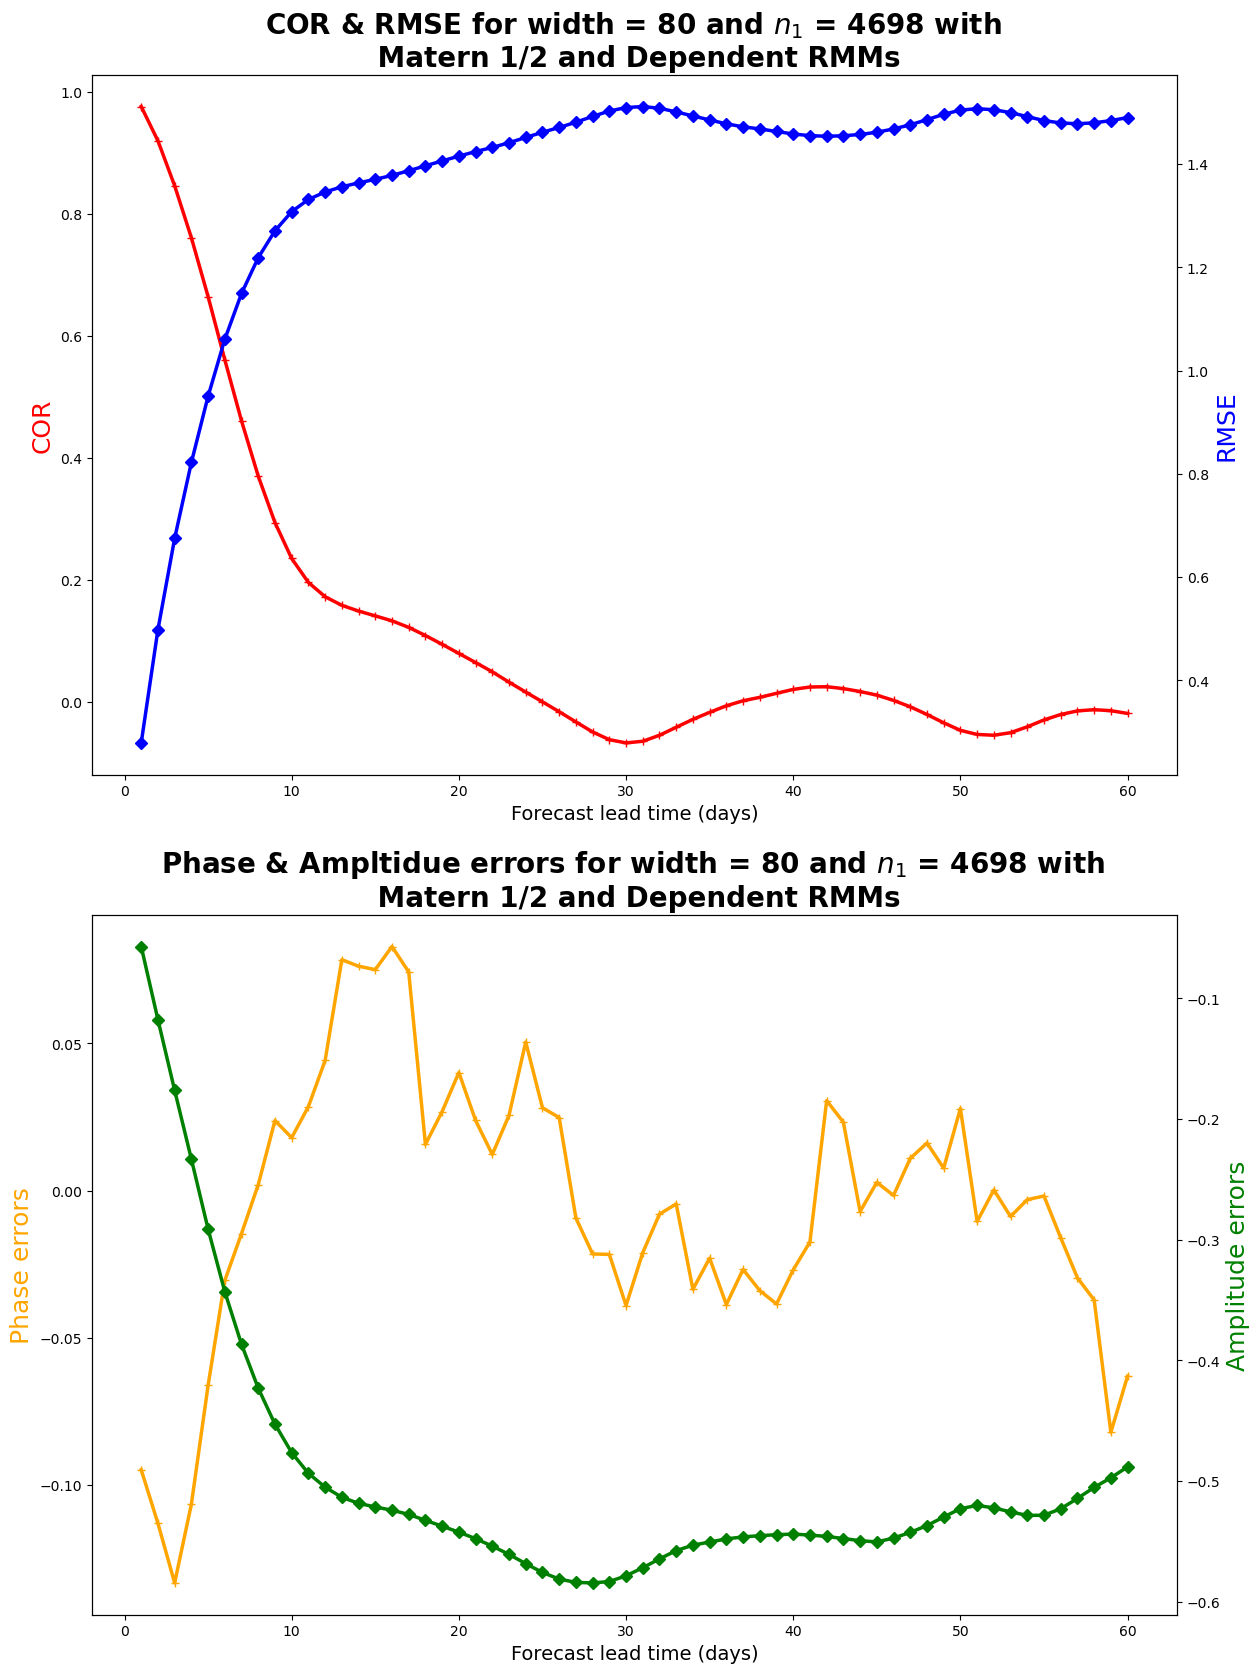

In [9]:
load_file = open('../data/preds/entire/matern12_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())

# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Matern 1/2 and Dependent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Matern 1/2 and Dependent RMMs', fontsize=20, fontweight="bold")

## $w_1$ $Mat\acute{e}rn$ $1/2$ + $w_2$ $Mat\acute{e}rn$ $3/2$ + $w_3$ $Mat\acute{e}rn$ $5/2$

### Independent RMMs

In [10]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern import MaternAdditiveKernel
kernel = MaternAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_additivematern = {}
cor_total_additivematern = {}
rmse_total_additivematern = {}
phase_err_total_additivematern = {}
amplitude_err_total_additivematern = {}

t = PrettyTable(["width", "RMMs", "lengthscales", "weights"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_additivematern[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for data_name in ['RMM1','RMM2']:
            mjo_model.train_mjo(data_name)
            mjo_model.pred_mjo(data_name, lead_time, n_pred)
            weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
            t.add_rows( [[f'{width}', f'{data_name}', 
                          f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                          f'{weights}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_additivematern[n1] = cor_width
    rmse_total_additivematern[n1] = rmse_width
    phase_err_total_additivematern[n1] = phase_err_width
    amplitude_err_total_additivematern[n1] = amplitude_err_width

maternsum_independ = {'cor': cor_total_additivematern, 'rmse': rmse_total_additivematern, 
                     'phase': phase_err_total_additivematern, 'amplitude': amplitude_err_total_additivematern,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/maternsum_independ.pkl','wb')
pickle.dump(maternsum_independ, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with independent RMMs:'))
print(t)

$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with independent RMMs:

+-------+------+------------------------------------+---------------------------------------------+
| width | RMMs |            lengthscales            |                   weights                   |
+-------+------+------------------------------------+---------------------------------------------+
|   40  | RMM1 |  [4.8427005 7.2596154 6.970013 ]   | [8.6873805e-04 3.8831688e-02 9.6029961e-01] |
|   40  | RMM2 |  [7.840698  9.6692915 9.780722 ]   | [3.2932559e-05 3.6539587e-03 9.9631310e-01] |
|   60  | RMM1 |  [ 9.803015 11.043105 15.107624]   | [4.1537905e-06 9.4473729e-04 9.9905109e-01] |
|   60  | RMM2 |  [10.012688 11.344134 18.040697]   | [3.0406513e-06 7.4223144e-04 9.9925470e-01] |
|   80  | RMM1 |  [ 9.675761  8.861338 20.802076]   | [4.0854743e-06 5.2691191e-03 9.9472678e-01] |
|   80  | RMM2 | [10.091719   6.3939795 24.932823 ] | [2.4619774e-06 1.6486533e-02 9.8351097e-01] |
+-------+------+------------------------------------+---------------------------------------------+


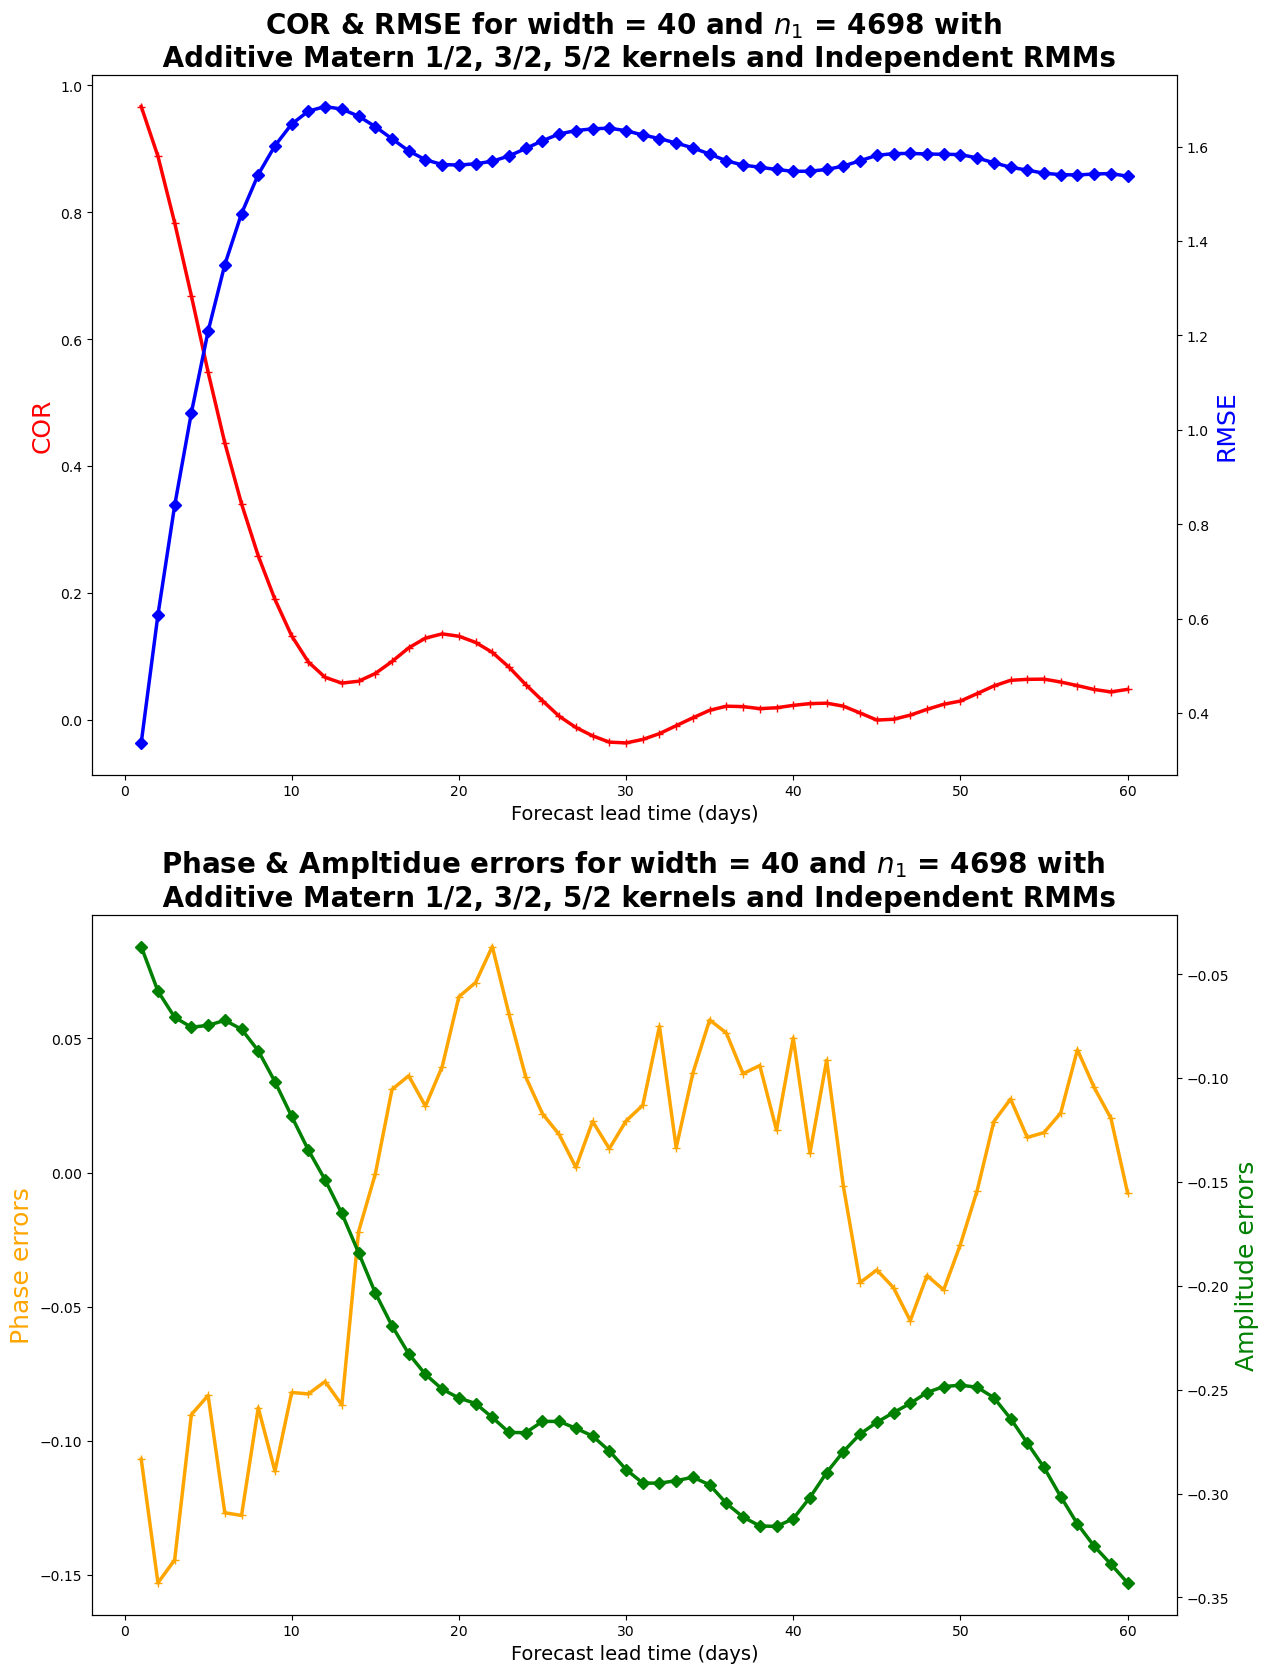

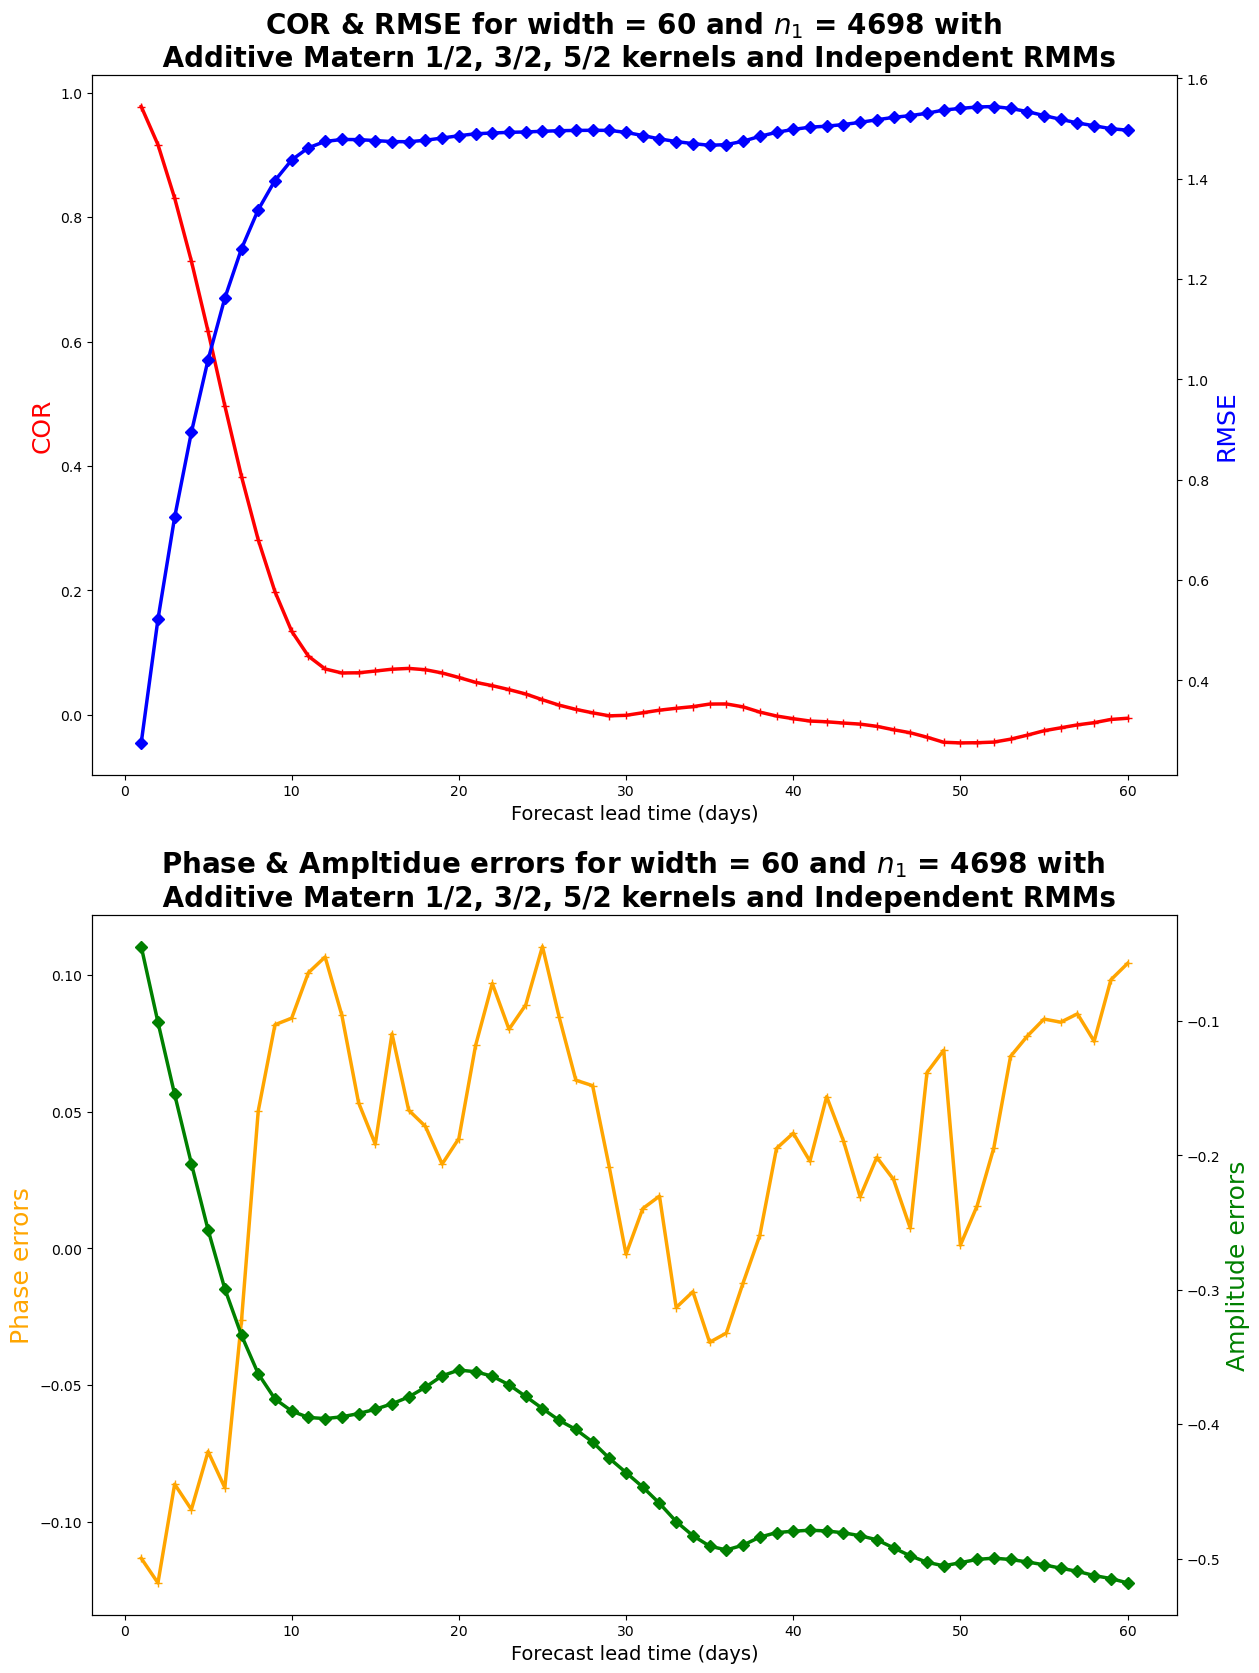

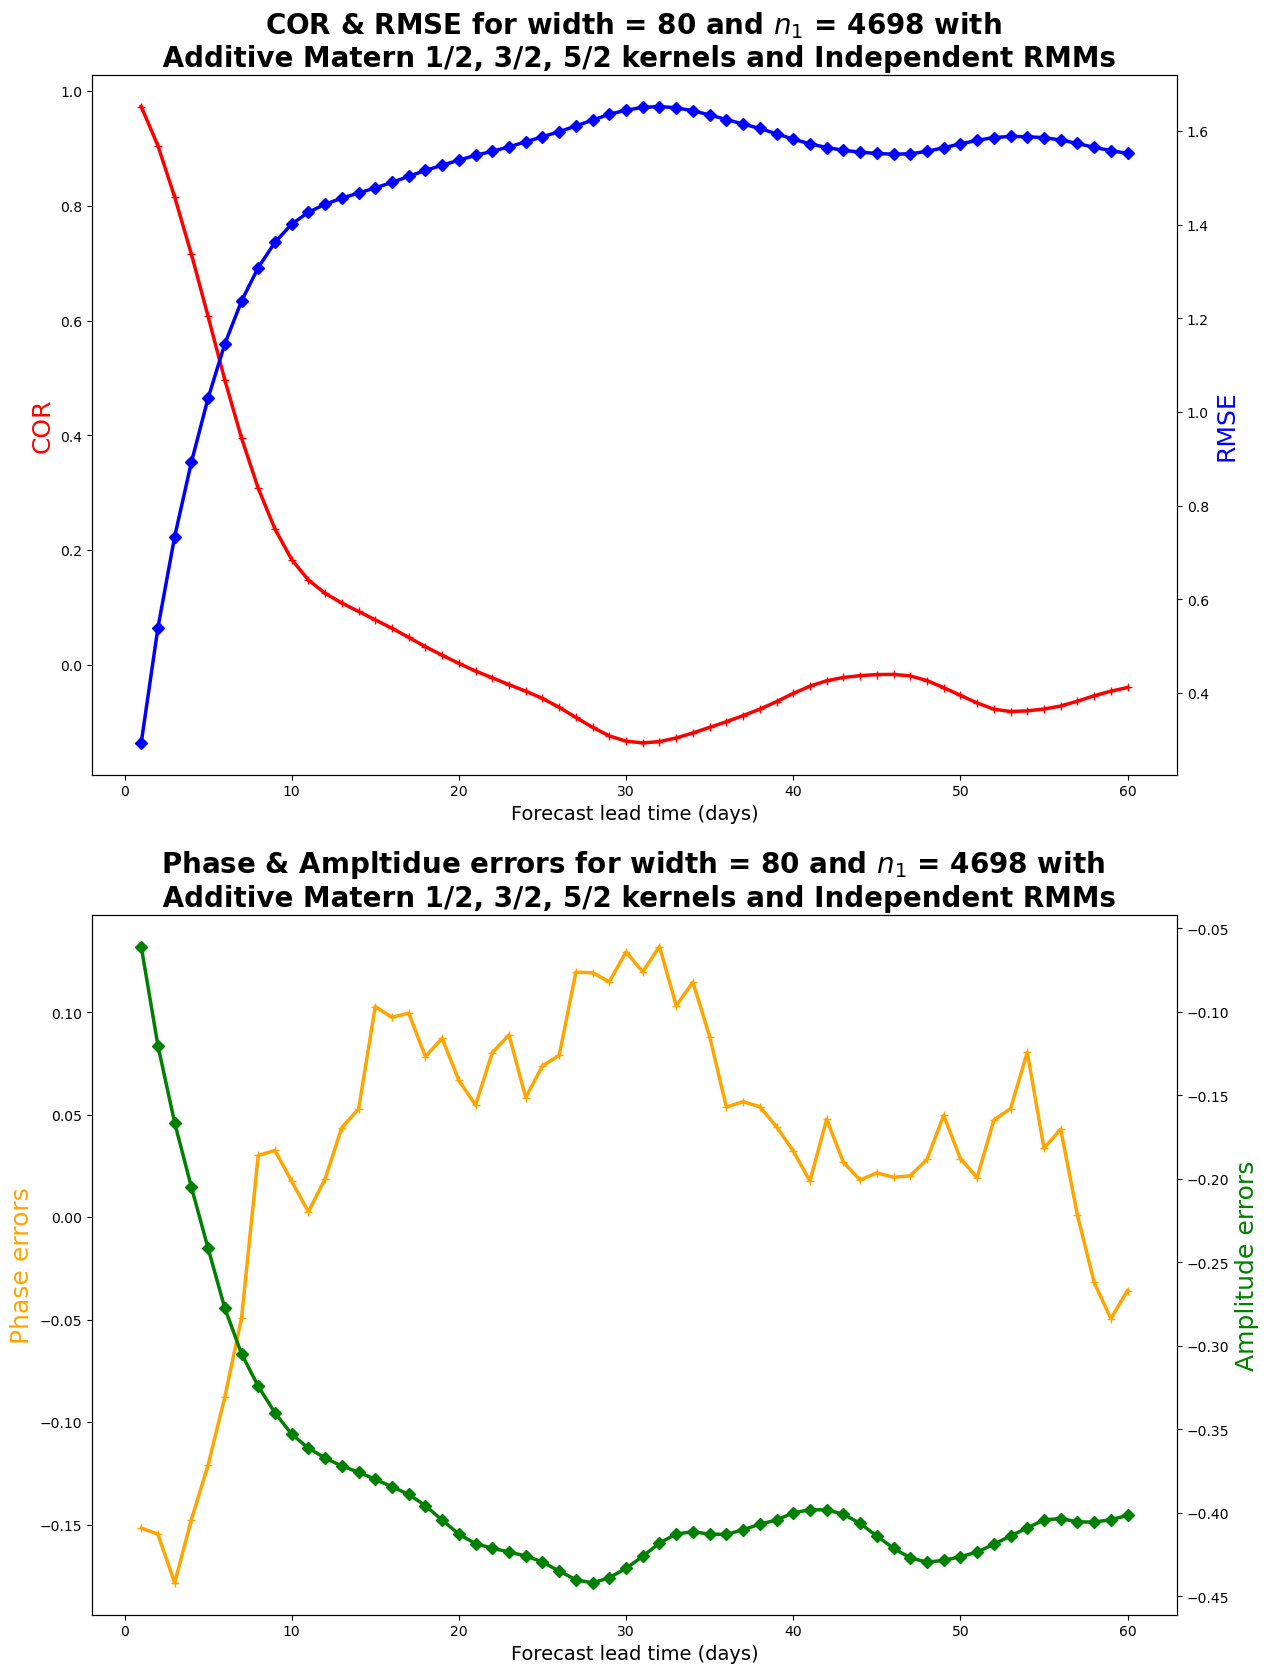

In [11]:
load_file = open('../data/preds/entire/maternsum_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())

# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Independent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs

In [6]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern import MaternAdditiveKernel
kernel = MaternAdditiveKernel(lengthscale_unique = False)

# Dependent
dics_total_dependadditivematern = {}
cor_total_dependadditivematern = {}
rmse_total_dependadditivematern = {}
phase_err_total_dependadditivematern = {}
amplitude_err_total_dependadditivematern = {}

t = PrettyTable(["width", "RMMs", "lengthscales", "weights"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_dependadditivematern[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        mjo_model.train_mjo(Depend=True)
        for data_name in ['RMM1','RMM2']:
            mjo_model.pred_mjo(data_name, lead_time, n_pred)
        weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
        t.add_rows( [[f'{width}', 'dependent', 
                      f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                      f'{weights}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_dependadditivematern[n1] = cor_width
    rmse_total_dependadditivematern[n1] = rmse_width
    phase_err_total_dependadditivematern[n1] = phase_err_width
    amplitude_err_total_dependadditivematern[n1] = amplitude_err_width

maternsum_depend = {'cor': cor_total_dependadditivematern, 'rmse': rmse_total_dependadditivematern, 
                     'phase': phase_err_total_dependadditivematern, 'amplitude': amplitude_err_total_dependadditivematern,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/maternsum_depend.pkl','wb')
pickle.dump(maternsum_depend, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with dependent RMMs:'))
print(t)


In [ ]:
load_file = open('../data/preds/entire/maternsum_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())

# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Dependent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Dependent RMMs', fontsize=20, fontweight="bold")

## $w_1$ $Mat\acute{e}rn$ $1/2$ + $w_2$ $Mat\acute{e}rn$ $3/2$ + $w_3$ $Mat\acute{e}rn$ $5/2$ + $w_4$ Periodic

### Independent RMMs

In [ ]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern_period import CustomAdditiveKernel
kernel = CustomAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_additiveperiod = {}
cor_total_additiveperiod = {}
rmse_total_additiveperiod = {}
phase_err_total_additiveperiod = {}
amplitude_err_total_additiveperiod = {}

t = PrettyTable(["width", "RMMs", "lengthscales", "weights"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_additiveperiod[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for data_name in ['RMM1','RMM2']:
            mjo_model.train_mjo(data_name)
            mjo_model.pred_mjo(data_name, lead_time, n_pred)

            weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
            t.add_rows( [[f'{width}', f'{data_name}', 
                          f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                          f'{weights}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_additiveperiod[n1] = cor_width
    rmse_total_additiveperiod[n1] = rmse_width
    phase_err_total_additiveperiod[n1] = phase_err_width
    amplitude_err_total_additiveperiod[n1] = amplitude_err_width

periodsum_independ = {'cor': cor_total_additiveperiod, 'rmse': rmse_total_additiveperiod, 
                     'phase': phase_err_total_additiveperiod, 'amplitude': amplitude_err_total_additiveperiod,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/periodsum_independ.pkl','wb')
pickle.dump(periodsum_independ, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 + $w_4$ Periodic with independent RMMs:'))
print(t)

In [ ]:
load_file = open('../data/preds/entire/periodsum_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())


# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Independent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMS

In [ ]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern_period import CustomAdditiveKernel
kernel = CustomAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_dependadditiveperiod = {}
cor_total_dependadditiveperiod = {}
rmse_total_dependadditiveperiod = {}
phase_err_total_dependadditiveperiod = {}
amplitude_err_total_dependadditiveperiod = {}

t = PrettyTable(["width", "RMMs", "lengthscales", "weights"])

for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total_dependadditiveperiod[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        mjo_model.train_mjo(Depend=True)
        for data_name in ['RMM1','RMM2']:
            mjo_model.pred_mjo(data_name, lead_time, n_pred)

        weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
        t.add_rows( [[f'{width}', 'dependent', 
                      f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}', 
                      f'{weights}']] )

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total_dependadditiveperiod[n1] = cor_width
    rmse_total_dependadditiveperiod[n1] = rmse_width
    phase_err_total_dependadditiveperiod[n1] = phase_err_width
    amplitude_err_total_dependadditiveperiod[n1] = amplitude_err_width

periodsum_depend = {'cor': cor_total_dependadditiveperiod, 'rmse': rmse_total_dependadditiveperiod, 
                     'phase': phase_err_total_dependadditiveperiod, 'amplitude': amplitude_err_total_dependadditiveperiod,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/entire/periodsum_depend.pkl','wb')
pickle.dump(periodsum_depend, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 + $w_4$ Periodic with dependent RMMs:'))
print(t)

In [ ]:
load_file = open('../data/preds/entire/periodsum_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
n1s = list(dic_file['cor'].keys())
widths = list(dic_file['cor'][n1s[0]].keys())


# Plot
for n1 in n1s:
    for width in widths:
        _cor = dic_file['cor'][n1][width]
        _rmse = dic_file['rmse'][n1][width]
        _phase_err = dic_file['phase'][n1][width]
        _amplitude_err = dic_file['amplitude'][n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
        ax0 = axs[0].twinx()
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        ax0.plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].set_ylabel('COR', color= 'red', fontsize=18)
        ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
        # axs[0].legend(['COR'], fontsize=14)
        # ax0.legend(['RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Dependent RMMs', fontsize=20, fontweight="bold")

        ax1 = axs[1].twinx()
        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        ax1.plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
        ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
        # axs[1].legend(['phase error'], fontsize=14)
        # ax1.legend(['amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Dependent RMMs', fontsize=20, fontweight="bold")

## Block Kernels for Dependent RMMs